Please do one of the following.


# Part I: Classification

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [34]:
import pandas as pd
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
import pylab
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
import re
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
import random
from sklearn import preprocessing
pd.set_option('display.max_columns', 500)

df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [35]:
df_default=pd.get_dummies(df['default'])
df_default.columns = ['Default_No', 'Default_Yes']
df_student=pd.get_dummies(df['student'])
df_student.columns = ['Student_No', 'Student_Yes']
df_final = pd.concat([df[['balance','income']],df_default, df_student],axis=1)
df_final.head()

,balance,income,Default_No,Default_Yes,Student_No,Student_Yes
1,729.526495,44361.625074,1,0,1,0
2,817.180407,12106.134700,1,0,0,1
3,1073.549164,31767.138947,1,0,1,0
4,529.250605,35704.493935,1,0,1,0
5,785.655883,38463.495879,1,0,1,0


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

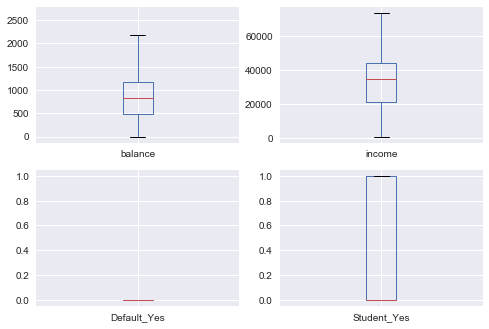

In [36]:
fig = plt.figure()
axes = fig.subplots(nrows=2, ncols=2)
plt.subplot(2, 2, 1)
df_final[['balance']].boxplot()
plt.subplot(2, 2, 2)
df_final[['income']].boxplot()
plt.subplot(2, 2, 3)
df_final[['Default_Yes']].boxplot()
plt.subplot(2, 2, 4)
df_final[['Student_Yes']].boxplot()
plt.show()

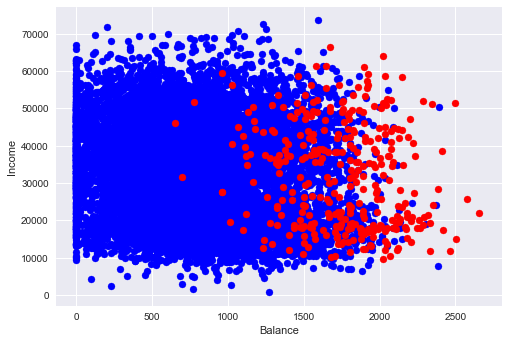

In [37]:
df_default_no = df_final.loc[df_final['Default_No'] == 1]
df_default_yes = df_final.loc[df_final['Default_Yes'] == 1]
plt.scatter(df_default_no['balance'],df_default_no['income'], c='blue')
plt.scatter(df_default_yes['balance'],df_default_yes['income'], c='red')
plt.xlabel('Balance')
plt.ylabel('Income')
plt.show()

##### Comments:

As can be observed from the scatterplot, people are more likely to default if their balance is high, regardless of their income levels

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

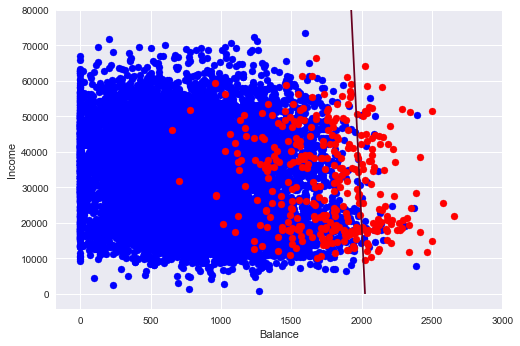

In [38]:
X = df_final.iloc[:,0:2]
y = df_final.iloc[:,3]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
classifier = LogisticRegression(C=0.1,penalty='l1')
classifier.fit(X_train, y_train)

X_grid = np.arange(0, 3000)
Y_grid = np.arange(0, 80000, 25)
xx, yy = np.meshgrid(X_grid, Y_grid)
grid = np.c_[xx.ravel(), yy.ravel()]
simulated_probs = classifier.predict_proba(grid)[:,1].reshape(xx.shape)

plt.contour(xx, yy, simulated_probs, levels=[.5], cmap="RdBu")
plt.scatter(df_default_no['balance'],df_default_no['income'], c='blue')
plt.scatter(df_default_yes['balance'],df_default_yes['income'], c='red')
plt.xlabel('Balance')
plt.ylabel('Income')
plt.show()

##### Comments:

We can see from the decision boundary that the regression model that we trained is quite good at classifying the data. Most of the points on the right of the decision boundary are coloured red (representing defaults) and most on the left are coloured blue (representing non-defaults). 

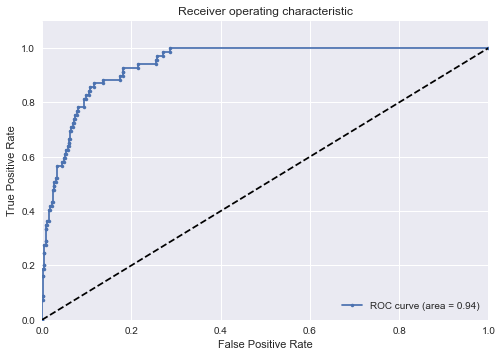

Area under the ROC curve : 0.942509


In [41]:
# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print("Area under the ROC curve : %f" % roc_auc)

##### Comments:

From the AUC ROC, we find that the model is quite a good classifier. A score of 0.942 suggests that most of the data points have been accurately classified by the classifier. 

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

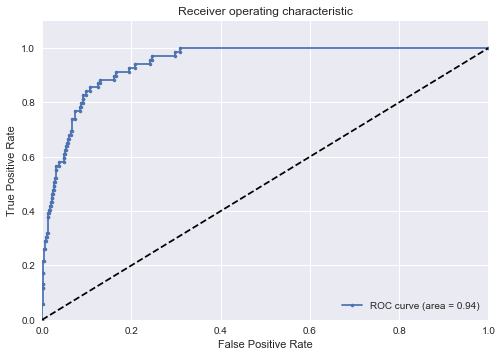

Area under the ROC curve : 0.943545


In [42]:
X2 = df_final.iloc[:,[0,1,-1]]

scaler = StandardScaler()
X2_standardised = X2.as_matrix().astype(np.float)
X2_standardised = scaler.fit_transform(X2_standardised)

fpr,tpr,roc_auc, thresholds = generate_auc(X2_standardised,y,LogisticRegression,C=0.1,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print("Area under the ROC curve : %f" % roc_auc)

##### Comments:

I now include the student variable. However, before I train the classifier model, I have additionally standardised the variables since we want to compare feature importance and plot a ranking of coefficients. 

From the AUC ROC, we find that this new model which includes the student variable is a slightly better classifier with a slightly higher score of 0.943. 

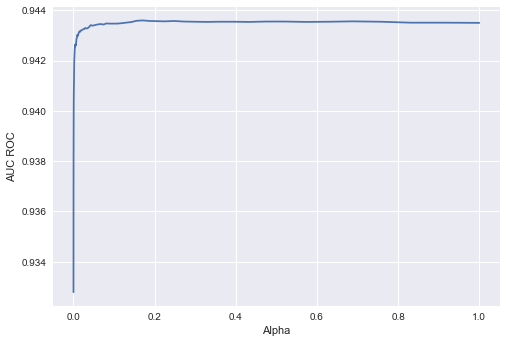

Optimal Alpha: 0.1707352647


In [43]:
X2_standardised_train, X2_standardised_test, y_train, y_test = train_test_split(
    X2_standardised, y, test_size=0.2, random_state=42)

alphas = np.logspace(-4,0,100)

scores = []

for alpha in alphas:
    fpr, tpr, roc_auc, thresholds= generate_auc(X2_standardised,y,LogisticRegression,C=alpha,penalty='l2')
    scores.append(roc_auc)
    
plt.plot(alphas,scores)
plt.xlabel('Alpha')
plt.ylabel('AUC ROC')
plt.show()

alpha_best = alphas[np.argmax(scores)]
print('Optimal Alpha: %.10f' % alpha_best)

##### Comments:

I now optimise the model using Ridge regression. This was done by running a logistic regression with an l2 penalty, as has been shown in lecture examples. 

From the optimisation, we find that the optimum regularisation parameter is in fact 0.1707. 

[[ 2.60153609  0.07401856 -0.17781258]]


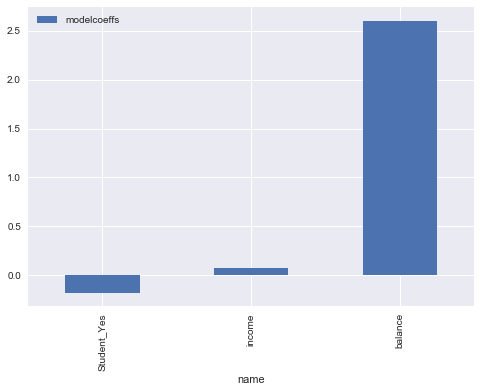

In [44]:
modelcoef =  LogisticRegression(C=alpha_best,penalty='l1').fit(X2_standardised_train,y_train).coef_
print(modelcoef)


df_coeffs1 = pd.DataFrame({'modelcoeffs':modelcoef[0], 'name':pd.DataFrame(X2).columns.values})
(df_coeffs1.sort_values(['modelcoeffs'])).plot(x='name',y='modelcoeffs', kind='bar')
plt.show()

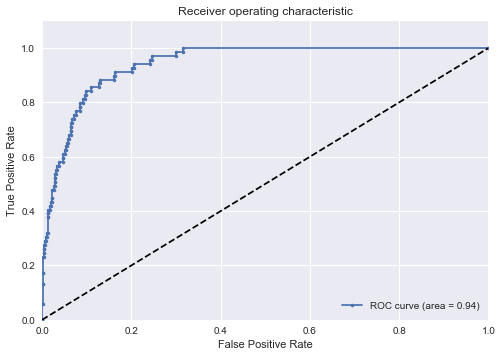

Area under the ROC curve : 0.943500


In [45]:
fpr,tpr,roc_auc, thresholds = generate_auc(X2_standardised,y,LogisticRegression,C=alpha_best,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print("Area under the ROC curve : %f" % roc_auc)

##### Comments:

I now run the logistic regression classifier model with the optimum regularisation parameter. This new model performs similarly well as when I used a regularisation parameter of 0.1. Both models give an auc roc score of 0.943.

When I plot the ranking of coefficients in this new model, I find that the best predictor of defaults is balance as it has a high coefficient of over 2.5. The impact of income is marginal (near 0) and the impact of being a student is slightly negative (students are less likely to default, all else being equal). 

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

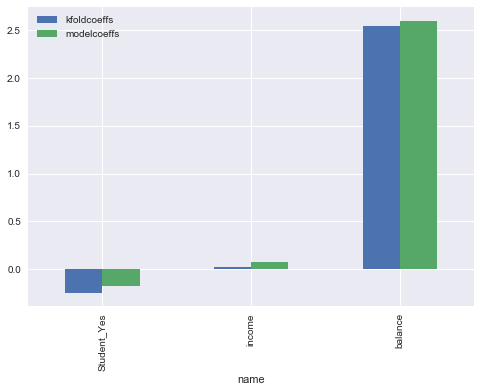

In [46]:
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True, random_state = np.random.RandomState(36))
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        coeffs.append(clf.coef_)
    return coeffs

coeffs=run_cv_coeffs(X2_standardised,np.array(y),LogisticRegression,C=alpha_best,penalty='l1')
from itertools import chain
coeffs = list(chain.from_iterable(coeffs))

def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(pd.DataFrame(X2_standardised).columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(pd.DataFrame(X2_standardised).columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

df_coeffs2 = pd.DataFrame({'name':pd.DataFrame(X2).columns.values, 'modelcoeffs':modelcoef[0], 'kfoldcoeffs':coeffs_avg})
(df_coeffs2.sort_values(['kfoldcoeffs'])).plot(x='name',kind='bar')
plt.show()

In [47]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LogisticRegression(C=alpha_best,penalty='l1').fit(X2_standardised_train,y_train), X2_standardised, y, cv=5, scoring="roc_auc")
scores

array([ 0.95330226,  0.95805615,  0.93821374,  0.96297167,  0.9355218 ])

##### Comments:

Using k-fold cross-validation, we can check whether our model in (5) is robust in two ways. 

First, we can compare the coefficients in our (5) model is similar to the average coefficients of the k-fold models. Indeed, from the plot above we find that this is the case. 

Second, we can compare the auc roc score of our kfold models to our (5) model. Indeed, we find that the auc roc scores of our kfold models and our (5) model are all similarly high above 0.93.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

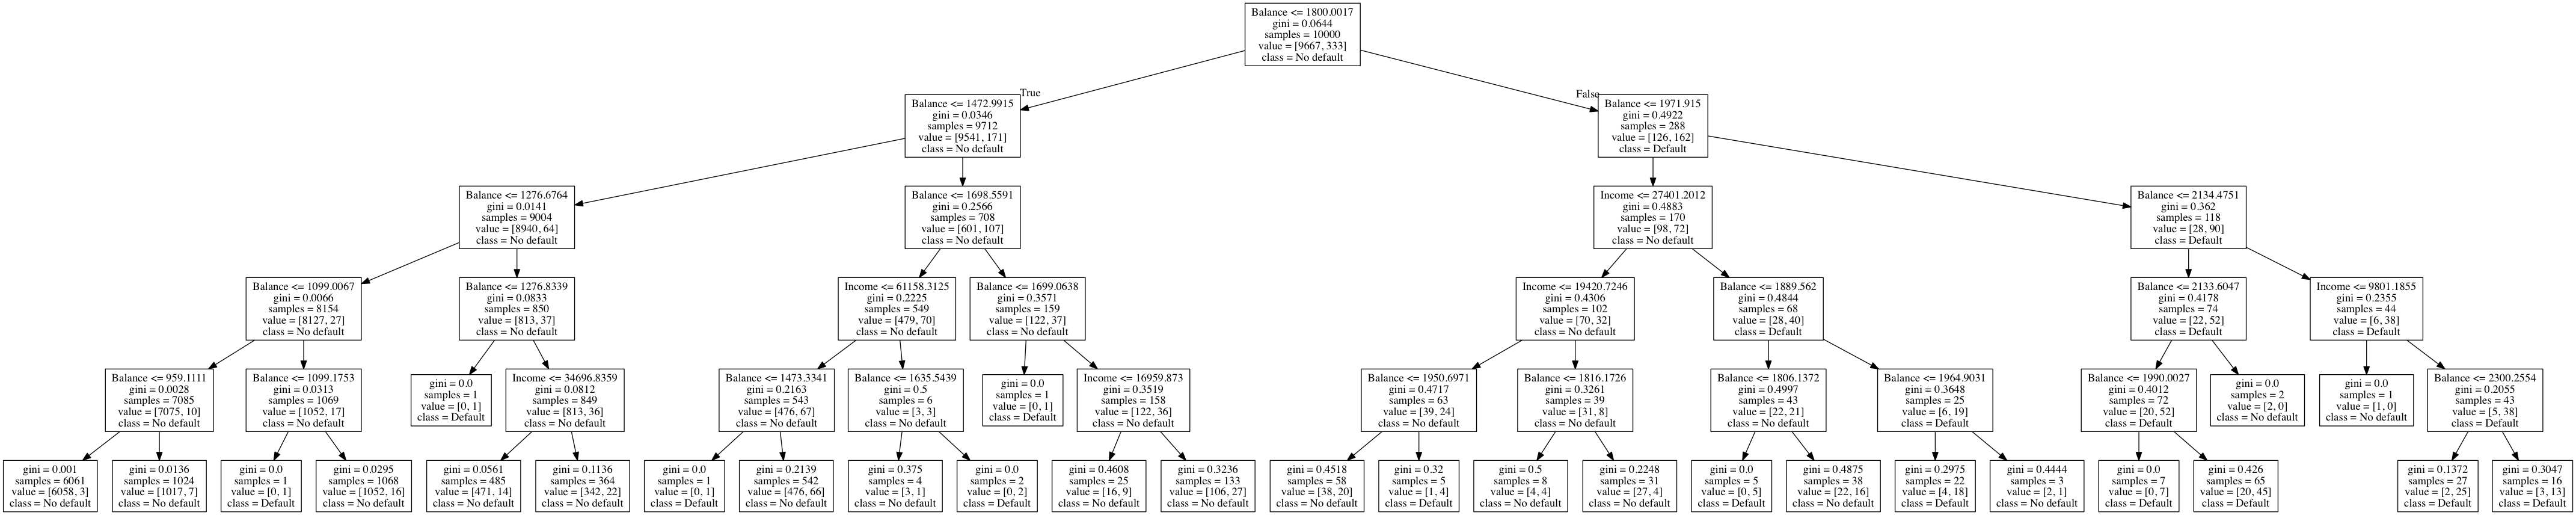

In [48]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy.random as nprnd
import random
import seaborn

def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        
from __future__ import print_function

import os
import subprocess
import pydotplus
from PIL import Image
from io import BytesIO


import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
decisiontree = DecisionTreeClassifier(max_depth=5)
decisiontree.fit(X2, y)

dot_data=export_graphviz(decisiontree, out_file=None, feature_names=['Balance', 'Income', 'Student'], class_names=['No default', 'Default'])
graph = pydotplus.graph_from_dot_data(dot_data)  
Image.open(BytesIO(graph.create_png()))

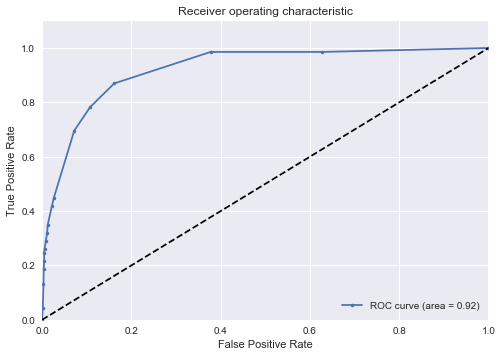

Area under the ROC curve : 0.921757


In [49]:
fpr,tpr,roc_auc, thresholds = generate_auc(X2,y,DecisionTreeClassifier, max_depth=5)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print("Area under the ROC curve : %f" % roc_auc)

##### Comments:

As can be seen from the auc roc plot above, the decision tree classifier performs worse than the logistic regression classifier. The auc roc score of the decision tree classifier is only 0.921, which is smaller than the score of the logistic regression classifier of 0.943.

8) Find the optimal decision tree depth and compute the AUC ROC. 

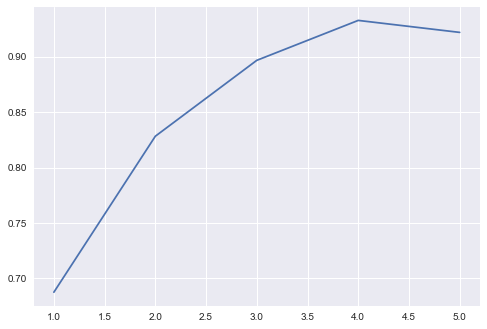

Optimal Decision Tree Depth: 4.0000000000


In [50]:
scores=[]
depths = range(1,6)
for n in depths:
    fpr, tpr, roc_auc, thresholds= generate_auc(X2,y,DecisionTreeClassifier, max_depth=n)
    scores.append(roc_auc)

n_opt=depths[np.argmax(scores)]    

plt.plot(depths,scores)
plt.show()
print('Optimal Decision Tree Depth: %.10f' % n_opt)

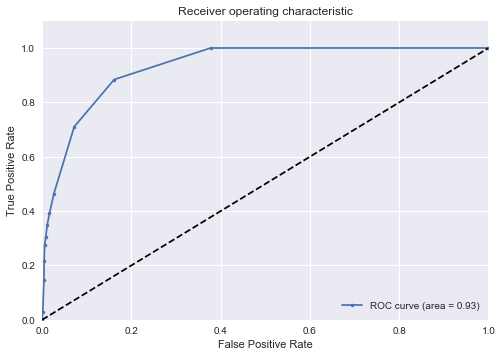

Area under the ROC curve : 0.932550


In [51]:
fpr,tpr,roc_auc, thresholds = generate_auc(X2,y,DecisionTreeClassifier, max_depth=4)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print("Area under the ROC curve : %f" % roc_auc)

##### Comments:

Using regularisation, we find that the optimum depth for the decision tree classifier should be 4, rather than 5.

With this new optimum depth, the auc roc score of our decision tree classifier improves to 0.932. However, this is still smaller than the score of our logistic regression classifier of 0.943.

# Part II: Recommendation Systems. 

In this problem we will use the notebook https://github.com/Columbia-Intro-Data-Science/APMAE4990-/blob/master/notebooks/matrix_factorization_recommender.ipynb  as
a starting point.

1) Split the ratings matrix `R_df` into training and testing sets. Remember we need to do this for rows and columns now. 

2) Evaluate the performance of the matrix factorization model for $K=50$. In particular, measure the:
 - Precision.
 - Recall. 

You can round up or down to the nearest integer for the ratings. 

3) Construct an item/item and user/user model, and evaluate the performance as in 2). How does it compare?

4) Check how your answer to 3) changes (if at all) as you try different values of K for K=10, 20, 100. 